In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os 
from astropy.io import ascii
from tqdm import tqdm
from astropy.convolution import convolve, Gaussian1DKernel
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
from scipy import stats
import pickle
from Doublet_Quantifier.curvefit import *
from Doublet_Quantifier.models import *


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
sys.path.append('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/')
from functions.data_tools import *
from functions.plotting_tools import *


In [3]:
# opening pseudo-voigt parameter DataFrame
mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/'
with open(mypath + "diamondback-data/pickle_files/parameters/t1500_parameter_df.pkl", "rb") as f:
    parameter_df = pickle.load(f)

### preforming cross validation 

In [4]:
cv_data = parameter_df[parameter_df.clouds!=10] # taking out the nc as fsed is not reliable

# defining the cross-validation data for easy access 
cv_A = ((cv_data.A1 + cv_data.A2)/2 ).values
cv_fsed = cv_data.clouds.values
cv_FWHM = ((cv_data.FWHM1 + cv_data.FWHM2)/2 ).values
cv_logg = cv_data.logg.values

# Create a linear regression model
model = LinearRegression()

# Performing loo cross-validation for logg
loo = LeaveOneOut()
squared_errors = []

for train_index, test_index in loo.split(cv_FWHM):
    X_train, X_test = cv_FWHM[train_index].reshape(-1, 1), cv_FWHM[test_index].reshape(-1, 1)
    y_train, y_test = cv_logg[train_index].reshape(-1, 1), cv_logg[test_index].reshape(-1, 1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    squared_errors.append((y_pred - y_test) ** 2)

RMSE_logg = np.sqrt(np.mean(squared_errors))
Pearson_corr_coef_1, p_value = stats.pearsonr(cv_logg, cv_FWHM)

# Print the cross-validation scores
print(f'Predictive Sum of Squares (PRESS)for logg: {RMSE_logg}')
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_1)
print("P-value:", p_value)
print()

# Performing loo cross-validation for fsed
squared_errors = []

for train_index, test_index in loo.split(cv_A):
    X_train, X_test = cv_A[train_index].reshape(-1, 1), cv_A[test_index].reshape(-1, 1)
    y_train, y_test = cv_fsed[train_index].reshape(-1, 1), cv_fsed[test_index].reshape(-1, 1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    squared_errors.append((y_pred - y_test) ** 2)

RMSE_fsed = np.sqrt(np.mean(squared_errors))
scores = cross_val_score(model, cv_A.reshape(-1, 1), cv_fsed.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error')
Pearson_corr_coef_2, p_value = stats.pearsonr(cv_fsed, cv_A)
# Print the cross-validation scores
print(f'Predictive Sum of Squares (PRESS)for fsed: {RMSE_fsed}')
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_2)
print("P-value:", p_value)



Predictive Sum of Squares (PRESS)for logg: 0.185123401882884
Pearson product-moment correlation coefficient: 0.9714962631535554
P-value: 7.069868614595015e-16

Predictive Sum of Squares (PRESS)for fsed: 1.1901043240638407
Pearson product-moment correlation coefficient: -0.8893428076131406
P-value: 2.79345452191496e-09


In [5]:
fsed_values = np.array([i for i in range(0,10)])
logg_values = np.array([i for i in range(3,7)])

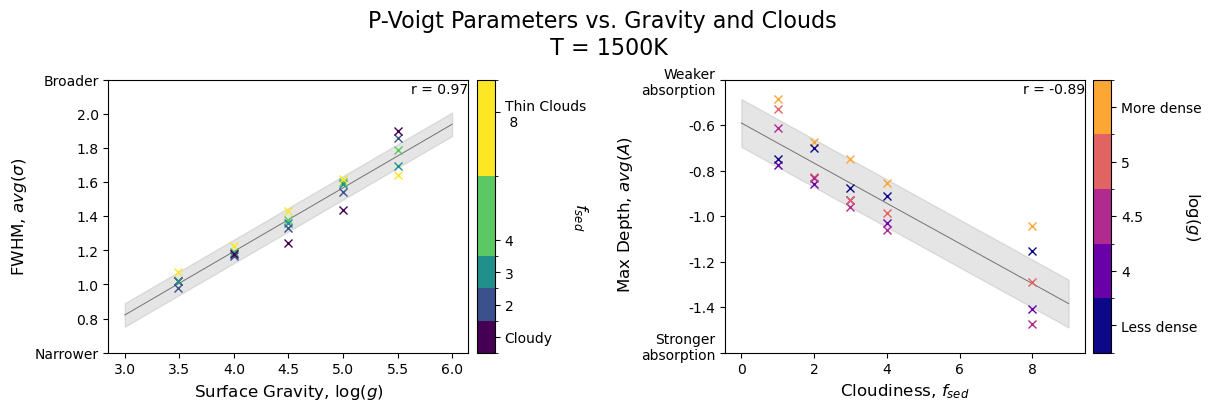

In [14]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True)

gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.05, 1, 0.05])

ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])
cax1, cax2 = fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 3]) 

# plotting data points 
for i in range(len(cv_FWHM)):
        ax1.errorbar(cv_logg[i], cv_FWHM[i],
                    color=fsed_colors(norm_f(cv_fsed[i])), fmt='x')
        ax2.errorbar(cv_fsed[i], cv_A[i], 
                    color=logg_colors(norm_g(cv_logg[i])), fmt='x')

# plotting lines 
m, b = np.polyfit(cv_logg, cv_FWHM, 1)
y_est = logg_values*m + b
ax1.plot(logg_values, y_est, color='k',
        linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (logg_values+ RMSE_logg)*m + b
lower_bound = (logg_values- RMSE_logg)*m + b
ax1.fill_between(logg_values, lower_bound, upper_bound, alpha=0.2, color = 'grey')


m, b = np.polyfit(cv_fsed, cv_A, 1)
y_est = fsed_values*m + b
ax2.plot(fsed_values, y_est, color='k',
        linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (fsed_values - RMSE_fsed)*m + b
lower_bound = (fsed_values + RMSE_fsed)*m + b
ax2.fill_between(fsed_values, lower_bound, upper_bound, alpha=0.2, color = 'grey')

# Colorbar

axcb = logg_colorbar(fig, cax = cax2,  orientation='vertical')
axcb.set_label(r'$\log(g)$' , fontsize=12, rotation = -90, labelpad=0) 



axcb = fsed_colorbar(fig, cax = cax1,  orientation='vertical')
axcb.set_label(r'$f_{sed}$', fontsize=12, rotation = -90, labelpad=0) 



# r value 
ax1.annotate(f"r = {Pearson_corr_coef_1:.2}", xy=(1, 0.99),
            ha='right', va='top',
            fontsize=10,
            xycoords='axes fraction', color='k')
ax2.annotate(f"r = {Pearson_corr_coef_2:.2}", xy=(1, 0.99),
            ha='right', va='top',
            fontsize=10,
            xycoords='axes fraction', color='k')

# set axis
yticks = ax2.get_yticks()
ylabel = list(yticks.copy()/1e11)
ylabel[0] = "Stronger\nabsorption\n"
ylabel[-1] = "Weaker\nabsorption"
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabel)

yticks = ax1.get_yticks()
ylabel = list(np.around(yticks.copy()/1e-3, 1))
ylabel[-1] = "Broader"
ylabel[0] = "Narrower"
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabel)
ax1.set_yticks(yticks)



# set labels
ax2.set_ylabel("\n Max Depth, $avg(A)$", fontsize=12)
ax1.set_ylabel("FWHM, $avg(\sigma)$", fontsize=12)
ax1.set_xlabel("Surface Gravity, " + r'$\log(g)$', fontsize=12)
ax2.set_xlabel("Cloudiness, " + r"$f_{sed}$", fontsize=12)

fig.suptitle('P-Voigt Parameters vs. Gravity and Clouds \n T = 1500K', fontsize=16)

plt.savefig("/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/CV_plot.png") 